In [ ]:
! pip install numba
import numba
from numba import cuda
from numba.cuda.cudadrv import enums
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from numba import vectorize
import math

from google.colab import drive
drive.mount("/content/drive/")

params = {
    'figure.figsize': [15, 10],  # instead of 4.5, 4.5
    'axes.titlesize': 15,
    'axes.labelsize': 10,
    'axes.linewidth': 0.5,
    'font.size': 20,
    'font.family': 'monospace',
    #    'font.monospace': 'Alma Mono',
    'legend.fontsize': 15,
    'legend.loc': 'upper right',
    'legend.labelspacing': 0.25,
    # 'xtick.labelsize': 20,
    # 'ytick.labelsize': 20,
    'lines.linewidth': 3,
    'text.usetex': False,
    # 'figure.autolayout': True,
    'ytick.right': False,
    'xtick.top': False,

    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,

    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,

    'xtick.major.pad': 2,
    'ytick.major.pad': 2,
    # 'xtick.minor.pad': 14,
    # 'ytick.minor.pad': 14,

    'xtick.direction': 'inout',
    'ytick.direction': 'inout',

    'grid.linestyle': '-',         # solid
    'grid.linewidth': 1.5,        # in points
    'grid.alpha':     1,        # transparency, between 0.0 and 1.0
}
# plt.style.use('fivethirtyeight')
matplotlib.rcParams.update(params)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


WITH SM

In [ ]:
# @title
from numba.parfors.parfor import maximize_fusion_inner
from itertools import permutations

#LABWORK10 - FINE-ART TRANSFORMATION  - SM

Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Test_org.png"
#Image_path_2=Data_path+"Test_org_2.jpg"
#Image_path = "/1206564.png"

img_data=plt.imread(Image_path)
(imageHeight,imageWidth,_)=img_data.shape
pixelCount = imageWidth * imageHeight
out_img = np.array(img_data, copy=True)
# blockDim.x,y,z gives the number of threads in a block, in the particular direction
# gridDim.x,y,z gives the number of blocks in a grid, in the particular direction
# blockDim.x * gridDim.x gives the number of threads in a grid


# png: already in [0,1]
# jpg: range [0 255] -> convert to [0 1]
# RGB to HSV
@cuda.jit
def scale_rgb_hsv(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  r = float(src[tidx,tidy,0])
  g = float(src[tidx,tidy,1])
  b = float(src[tidx,tidy,2])
  max_color=max(r,g,b)
  min_color=min(r,g,b)
  delta = max_color - min_color

  # Hue

  #0 must be float to match with delta
  if delta == np.float64(0):
    h = 0
  elif max_color == r:
    h = float(60*(((g-b)/delta) %6))
  elif max_color == g:
    h = float(60*((b-r)/delta + 2))
  else:
    h = float(60*((r-g)/delta + 4))

  # saturation
  if max_color != 0:
    s = np.float32(delta/max_color)
  else:
    s = 0

  dst[tidx,tidy,0] = h
  dst[tidx,tidy,1] = s
  dst[tidx,tidy,2] = max_color


#HSV to RGB
@cuda.jit
def scale_hsv_rgb(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  h = src[tidx,tidy,0]
  s = src[tidx,tidy,1]
  v = src[tidx,tidy,2]

  d = float(h/60)
  hi = int(d%6)
  f = float(d - hi)
  l = float(v * (1-s))
  m = float(v * (1-f*s))
  n = float(v * (1 - (1-f)*s))

  if np.float64(0) <= h < np.float64(60):
    r = v
    g = n
    b = l
  elif np.float64(60) <= h < np.float64(120):
    r = m
    g = v
    b = l
  elif np.float64(120) <= h < np.float64(180):
    r = l
    g = v
    b = n
  elif np.float64(180) <= h < np.float64(240):
    r = l
    g = m
    b = v
  elif np.float64(240) <= h < np.float64(300):
    r = n
    g = l
    b = v
  else:
    r = v
    g = l
    b = m
  cuda.syncthreads()

  dst[tidx,tidy,0] = r * 255
  dst[tidx,tidy,1] = g * 255
  dst[tidx,tidy,2] = b * 255
  cuda.syncthreads()

class Kuwa_filter():
    @staticmethod
    def _gpu_kernel_factory():
        sum_op = cuda.jit(device=True)(lambda a, b: a + b)
        square_op = cuda.jit(device=True)(lambda a: a * a)

        @cuda.jit(device=True)
        def load_shared(input,shared_mem,old_mean,left,right,bot,top):
          tx = cuda.threadIdx.x
          ty = cuda.threadIdx.y
          x,y = cuda.grid(2)

          #if left <= x < right and bot <= y < top:
          if 0 <= x < input.shape[0] and 0 <= y < input.shape[1]:
              shared_mem[tx, ty] = input[x, y]
          else:
              shared_mem[tx, ty] = 1000

          cuda.syncthreads()


        @cuda.jit(device=True)
        def sum_reduce(output, shared_mem):
            tx = cuda.threadIdx.x
            ty = cuda.threadIdx.y
            block_dimx = cuda.blockDim.x
            block_dimy = cuda.blockDim.y

            jump = 1
            while jump < block_dimx:
              next = tx + jump
              if next < block_dimx:
                temp = shared_mem[next,ty]
                shared_mem[tx, ty] += temp
              cuda.syncthreads()
              jump = jump * 2

            jump = 1
            while jump < block_dimy:
              next = ty + jump
              if next < block_dimy:
                temp = shared_mem[tx, next]
                shared_mem[tx, ty] += temp
              cuda.syncthreads()
              jump = jump * 2
              cuda.syncthreads()

            if tx == 0 and ty == 0:
              #output[cuda.blockIdx.x] = 1000
              output[0] += shared_mem[0,0]

        @cuda.jit(device = True)
        def full_cal(block,left,right,bot,top,old_mean,output):
            tx = cuda.threadIdx.x
            ty = cuda.threadIdx.y
            #for i in range(shared_mem.shape[0]):
            #  for j in range(shared_mem.shape[1]):
            #    shared_mem[i, j] = 0
            output[0] = 0.0
            shared_mem = cuda.shared.array((8,8), dtype=numba.float32)
            load_shared(block,shared_mem,old_mean,left,right,bot,top)
            sum_reduce(output, shared_mem)
            output[0] = output[0] / (block.shape[0] * block.shape[1])


        # output must be a device array not local, not shared
        def kuwahara_filter(d_input,d_output,win_size,output):#,max_block_size = max_block_size):
            tidx,tidy = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x, cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
            (ho_dim,ver_dim,color_dim) = d_input.shape
            win_size_r = win_size // 2
            win_size_l = math.ceil(win_size / 2)
            if  win_size_r <= tidx <= ho_dim - win_size_r and win_size_r <= tidy <= ver_dim - win_size_r:
                left = cuda.local.array(4, dtype=numba.int32)
                right = cuda.local.array(4, dtype=numba.int32)
                bot = cuda.local.array(4, dtype=numba.int32)
                top = cuda.local.array(4, dtype=numba.int32)

                # Fill the arrays
                left[0] = tidx
                left[1] = tidx - win_size_r
                left[2] = tidx
                left[3] = tidx - win_size_r

                right[0] = tidx + win_size_l
                right[1] = tidx + 1
                right[2] = tidx + win_size_l
                right[3] = tidx + 1

                bot[0] = tidy
                bot[1] = tidy
                bot[2] = tidy - win_size_r
                bot[3] = tidy - win_size_r

                top[0] = tidy+win_size_l
                top[1] = tidy+win_size_l
                top[2] = tidy + 1
                top[3] = tidy + 1

                std_org = float(100)
                #output = cuda.local.array(3,dtype = numba.float32)
                v_org = None

                for i in range(4) :
                    block = d_input[left[i]:right[i], bot[i]:top[i],:]
                    full_cal(block[:,:,2],left[i], right[i], bot[i], top[i],None,output)
                    mean_v = output[0]
                    full_cal(block[:,:,2],left[i], right[i], bot[i], top[i], mean_v,output)
                    std_v = output[0]
                    #std_v = math.sqrt(variance)

                    if std_v <= std_org:
                        block_org = block
                        std_org = std_v
                        v_org = mean_v
                        left_org = left[i]
                        right_org = right[i]
                        bot_org = bot[i]
                        top_org = top[i]

                full_cal(block_org[:,:,0],left_org,right_org, bot_org,top_org,None,output)
                d_output[tidx,tidy,0] = output[0]
                full_cal(block_org[:,:,1],left_org,right_org, bot_org,top_org,None,output)
                d_output[tidx,tidy,1] = output[0]
                d_output[tidx,tidy,2] = v_org
                #"""
                #d_output[tidx,tidy,0] = d_input[tidx,tidy,0]
                #d_output[tidx,tidy,1] = d_input[tidx,tidy,0]
                """
                d_output[tidx,tidy,2] = d_input[tidx,tidy,0]
                """
            else:
                d_output[tidx,tidy,0] = d_input[tidx,tidy,0]
                d_output[tidx,tidy,1] = d_input[tidx,tidy,1]
                d_output[tidx,tidy,2] = d_input[tidx,tidy,2]

        return cuda.jit(kuwahara_filter)

    def __init__(self):
        pass
    def __call__(self, src, blockSize, win_size = 7, option = True):

        #int to ensure it's an interger
        # BlockSize should be the multiplication of ,lim32
        (imageHeight,imageWidth,_)=src.shape
        gridSize = (imageHeight + blockSize - 1) // blockSize, (imageWidth + blockSize - 1) // blockSize
        blockSize_fin=(blockSize,blockSize)

        # Start timing
        start_time=time.time()
        # Copy image to the device from host(CPU)
        KuSrc = cuda.to_device(src)

        # Allocate memory on the device (GPU)
        KuDst = cuda.device_array((imageHeight,imageWidth,3), dtype = src.dtype)

        # flatten array
        win_size_l = math.ceil(win_size / 2 )
        #flatten_array = cuda.device_array(win_size_l * win_size_l , dtype = np.float32)

        # output_temp
        output_temp = cuda.device_array((1,), dtype = np.float32)

        Kuwa_kernel = self._gpu_kernel_factory()
        Kuwa_kernel[gridSize,blockSize_fin](KuSrc, KuDst, win_size,output_temp)

        # Copy from device to host
        finDst = KuDst.copy_to_host()

        # Stop timing
        end_time=time.time()

        #Get the running time
        run_time=end_time-start_time

        if option == True:
            return run_time, finDst
        else:
            return run_time


def compare(blockSize, img, colorspace = "rgb"):
    #Grid size -> chunk
    #int to ensure it's an interger
    # BlockSize should be the multiplication of 32
    grid_1 = int(imageHeight/blockSize)
    grid_2 = int(imageWidth/blockSize)
    print(grid_1,grid_2)
    gridSize=(grid_1,grid_2)
    blockSize=(blockSize,blockSize)

    # Start timing
    start_time=time.time()

    # Copy image to the device from host(CPU)
    devSrc = cuda.to_device(img)

    if colorspace == "rgb":
    # Allocate memory on the device (GPU)
      devDst = cuda.device_array((imageHeight,imageWidth,3), np.float32)
    # Reduce finding max, min
      scale_rgb_hsv[gridSize,blockSize](devSrc, devDst)
    else:
        # Allocate memory on the device (GPU)
      devDst = cuda.device_array((imageHeight,imageWidth,3), np.uint8)
      scale_hsv_rgb[gridSize,blockSize](devSrc, devDst)

    # Copy from device to host
    hostDst=devDst.copy_to_host()

    # Stop timing
    end_time=time.time()

    #Get the running time
    run_time=end_time-start_time

    return hostDst

In [ ]:
blockSize = 16
hsvDst= compare(blockSize,img_data)
blockSize = 8 #
Filter = Kuwa_filter()
for win_size in range(1,51,10):
  run_time_2,kuDst = Filter(hsvDst, blockSize, win_size, option = True)
  print(run_time_2,win_size)
rgbDst_test= compare(blockSize, hsvDst, colorspace = "hsv")
rgbDst= compare(blockSize, kuDst, colorspace = "hsv")
plt.imshow(rgbDst)

WITHOUT SM

In [ ]:
# @title
from numba.parfors.parfor import maximize_fusion_inner
from itertools import permutations

#LABWORK10 - FINE-ART TRANSFORMATION - WITHOUT SM

Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Test_org.png"
#Image_path_2=Data_path+"Test_org_2.jpg"
#Image_path = "/1206564.png"

img_data=plt.imread(Image_path)
(imageHeight,imageWidth,_)=img_data.shape
pixelCount = imageWidth * imageHeight
out_img = np.array(img_data, copy=True)
# blockDim.x,y,z gives the number of threads in a block, in the particular direction
# gridDim.x,y,z gives the number of blocks in a grid, in the particular direction
# blockDim.x * gridDim.x gives the number of threads in a grid


# png: already in [0,1]
# jpg: range [0 255] -> convert to [0 1]
# RGB to HSV
@cuda.jit
def scale_rgb_hsv(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  r = float(src[tidx,tidy,0])
  g = float(src[tidx,tidy,1])
  b = float(src[tidx,tidy,2])
  max_color=max(r,g,b)
  min_color=min(r,g,b)
  delta = max_color - min_color

  # Hue

  #0 must be float to match with delta
  if delta == np.float64(0):
    h = 0
  elif max_color == r:
    h = float(60*(((g-b)/delta) %6))
  elif max_color == g:
    h = float(60*((b-r)/delta + 2))
  else:
    h = float(60*((r-g)/delta + 4))

  # saturation
  if max_color != 0:
    s = np.float32(delta/max_color)
  else:
    s = 0

  dst[tidx,tidy,0] = h
  dst[tidx,tidy,1] = s
  dst[tidx,tidy,2] = max_color


#HSV to RGB
@cuda.jit
def scale_hsv_rgb(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  h = src[tidx,tidy,0]
  s = src[tidx,tidy,1]
  v = src[tidx,tidy,2]

  d = float(h/60)
  hi = int(d%6)
  f = float(d - hi)
  l = float(v * (1-s))
  m = float(v * (1-f*s))
  n = float(v * (1 - (1-f)*s))

  if np.float64(0) <= h < np.float64(60):
    r = v
    g = n
    b = l
  elif np.float64(60) <= h < np.float64(120):
    r = m
    g = v
    b = l
  elif np.float64(120) <= h < np.float64(180):
    r = l
    g = v
    b = n
  elif np.float64(180) <= h < np.float64(240):
    r = l
    g = m
    b = v
  elif np.float64(240) <= h < np.float64(300):
    r = n
    g = l
    b = v
  else:
    r = v
    g = l
    b = m
  cuda.syncthreads()

  dst[tidx,tidy,0] = r * 255
  dst[tidx,tidy,1] = g * 255
  dst[tidx,tidy,2] = b * 255
  cuda.syncthreads()

class Kuwa_filter():
    @staticmethod
    def _gpu_kernel_factory():
        sum_op = cuda.jit(device=True)(lambda a, b: a + b)
        square_op = cuda.jit(device=True)(lambda a: a * a)

        @cuda.jit(device=True)
        def full_cal(input,old_mean,output):
            dim = input.shape[0] * input.shape[1]
            sum = 0
            output[0] = 0.0
            for x in range(input.shape[0]):
                for y in range(input.shape[1]):
                  if old_mean is not None:
                    temp = square_op(input[x,y] - old_mean)
                  else:
                    temp = input[x,y]
                  sum += temp
            output[0] = sum / dim
            return output[0]

        # output must be a device array not local, not shared
        def kuwahara_filter(d_input,d_output,win_size,output):#,max_block_size = max_block_size):
            tidx,tidy = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x, cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
            (ho_dim,ver_dim,color_dim) = d_input.shape
            win_size_r = win_size // 2
            win_size_l = math.ceil(win_size / 2)
            if  win_size_r <= tidx <= ho_dim - win_size_r and win_size_r  <= tidy <= ver_dim - win_size_r:
                left = cuda.local.array(4, dtype=numba.int32)
                right = cuda.local.array(4, dtype=numba.int32)
                bot = cuda.local.array(4, dtype=numba.int32)
                top = cuda.local.array(4, dtype=numba.int32)

                # Fill the arrays
                left[0] = tidx
                left[1] = tidx - win_size_r
                left[2] = tidx
                left[3] = tidx - win_size_r

                right[0] = tidx + win_size_l
                right[1] = tidx + 1
                right[2] = tidx + win_size_l
                right[3] = tidx + 1

                bot[0] = tidy
                bot[1] = tidy
                bot[2] = tidy - win_size_r
                bot[3] = tidy - win_size_r

                top[0] = tidy+win_size_l
                top[1] = tidy+win_size_l
                top[2] = tidy + 1
                top[3] = tidy + 1

                std_org = float(100)
                #output = cuda.local.array(3,dtype = numba.float32)
                v_org = None

                for i in range(4) :
                    block = d_input[left[i]:right[i],bot[i]:top[i],:]
                    mean_v = full_cal(block[:,:,2],None,output)
                    variance = full_cal(block[:,:,2],mean_v,output)
                    std_v = math.sqrt(variance)

                    if std_v <= std_org:
                        block_org = block
                        std_org = std_v
                        v_org = mean_v

                d_output[tidx,tidy,0] = full_cal(block_org[:,:,0],None,output)
                d_output[tidx,tidy,1] = full_cal(block_org[:,:,1],None,output)
                d_output[tidx,tidy,2] = v_org
                """
                d_output[tidx,tidy,0] = d_input[tidx,tidy,0]
                d_output[tidx,tidy,1] = d_input[tidx,tidy,0]
                d_output[tidx,tidy,2] = d_input[tidx,tidy,0]
                """
            else:
                d_output[tidx,tidy,0] = d_input[tidx,tidy,0]
                d_output[tidx,tidy,1] = d_input[tidx,tidy,1]
                d_output[tidx,tidy,2] = d_input[tidx,tidy,2]

        return cuda.jit(kuwahara_filter)

    def __init__(self):
        pass
    def __call__(self, src, blockSize, win_size = 7, option = True):

        #int to ensure it's an interger
        # BlockSize should be the multiplication of ,lim32
        (imageHeight,imageWidth,_)=src.shape
        gridSize = (imageHeight + blockSize - 1) // blockSize, (imageWidth + blockSize - 1) // blockSize
        blockSize_fin=(blockSize,blockSize)

        # Start timing
        start_time=time.time()
        # Copy image to the device from host(CPU)
        KuSrc = cuda.to_device(src)

        # Allocate memory on the device (GPU)
        KuDst = cuda.device_array((imageHeight,imageWidth,3), dtype = src.dtype)

        # flatten array
        win_size_l = math.ceil(win_size / 2 )
        #flatten_array = cuda.device_array(win_size_l * win_size_l , dtype = np.float32)

        # output_temp
        output_temp = cuda.device_array((1,), dtype = np.float32)

        Kuwa_kernel = self._gpu_kernel_factory()
        Kuwa_kernel[gridSize,blockSize_fin](KuSrc, KuDst, win_size,output_temp)

        # Copy from device to host
        finDst = KuDst.copy_to_host()

        # Stop timing
        end_time=time.time()

        #Get the running time
        run_time=end_time-start_time

        if option == True:
            return run_time, finDst
        else:
            return run_time


def compare(blockSize, img, colorspace = "rgb"):
    #Grid size -> chunk
    #int to ensure it's an interger
    # BlockSize should be the multiplication of 32
    grid_1 = int(imageHeight/blockSize)
    grid_2 = int(imageWidth/blockSize)
    print(grid_1,grid_2)
    gridSize=(grid_1,grid_2)
    blockSize=(blockSize,blockSize)

    # Start timing
    start_time=time.time()

    # Copy image to the device from host(CPU)
    devSrc = cuda.to_device(img)

    if colorspace == "rgb":
    # Allocate memory on the device (GPU)
      devDst = cuda.device_array((imageHeight,imageWidth,3), np.float32)
    # Reduce finding max, min
      scale_rgb_hsv[gridSize,blockSize](devSrc, devDst)
    else:
        # Allocate memory on the device (GPU)
      devDst = cuda.device_array((imageHeight,imageWidth,3), np.uint8)
      scale_hsv_rgb[gridSize,blockSize](devSrc, devDst)

    # Copy from device to host
    hostDst=devDst.copy_to_host()

    # Stop timing
    end_time=time.time()

    #Get the running time
    run_time=end_time-start_time

    return hostDst

In [ ]:
# @title
blockSize = 16
#WARP_SIZE = 32
#NUM_WARPS = 8 # TODO: num * size = 256
#max_block_size = NUM_WARPS * WARP_SIZE
hsvDst= compare(blockSize,img_data)
#print(hsvDst)

124 240


In [ ]:
# @title
blockSize = 8 #
Filter = Kuwa_filter()
for win_size in range(1,61,10):
  run_time_2,kuDst = Filter(hsvDst, blockSize, win_size = 3, option = True)
  print(run_time_2, win_size)

2.5158438682556152 1
2.4228477478027344 11
1.9417293071746826 21
1.6491286754608154 31
1.1472935676574707 41
1.0225446224212646 51


249 480
249 480


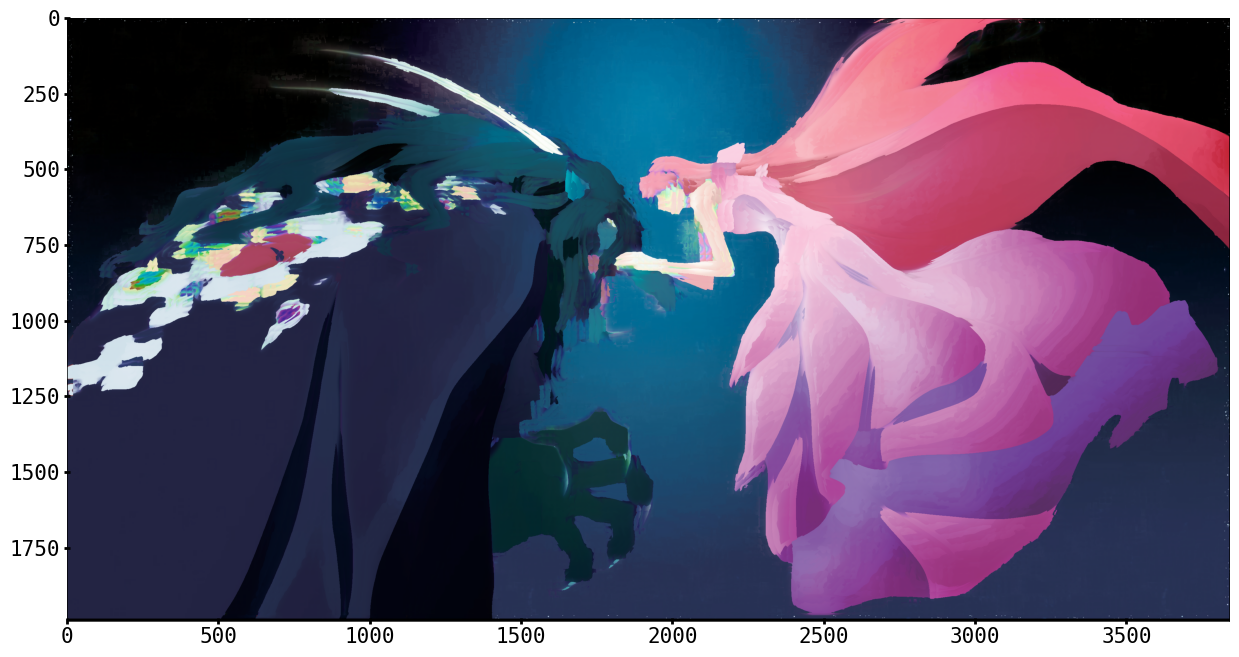

In [ ]:
# @title
blockSize = 8 #
win_size = 41
Filter = Kuwa_filter()
run_time_2,kuDst = Filter(hsvDst, blockSize, win_size, option = True)
rgbDst_test= compare(blockSize, hsvDst, colorspace = "hsv")
rgbDst= compare(blockSize, kuDst, colorspace = "hsv")
plt.imshow(rgbDst)